In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")

print("Path to dataset files:", path)
# Move dataset to a more accessible location

# mv /root/.cache/kagglehub/datasets/joosthazelzet/ <dest_path>

100%|██████████| 1.00G/1.00G [00:12<00:00, 88.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/joosthazelzet/lego-brick-images/versions/4


# Description

This is a simple GAN implemented entirely with MLPs, it represents the simplest GAN you can build.

## Discriminator

The discriminator has a single dense input layer with 28×28 (784) units, corresponding to each pixel of the MNIST dataset images. It uses a LeakyReLU activation function. In the original GAN paper, LeakyReLU is used because it generally gives better results.

This architecture is essentially a binary classifier that predicts whether an image generated by the generator is real or fake.

## Generator

The generator has a dense input layer that projects a noise vector to 256 units with a LeakyReLU activation (same as the discriminator). This is followed by another dense layer that maps the 256 features to 784 units, which correspond to the generated image of 28×28 pixels.

# Improvements

As this is an extremely simple GAN, there are several possible improvements:

- The network architecture could be made more complex to extract more features for both generation and discrimination.

- Since we are working with images, CNN layers could be used to better capture spatial features.

- Only one configuration of hyperparameters was tested, so experimenting with different values could improve results.

- Batch normalization could be applied to improve training stability and feature normalization.

As mentioned, this is the most basic approach to a GAN, there are many other GAN variants and architectures designed for a wide range of purposes.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
# from torch.utils.tensorboard import SummaryWriter

# Simple Discriminator network

In [4]:
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super().__init__()

    self.disc = nn.Sequential(
        nn.Linear(img_dim, 128), # input of 784 ( the generated image ) and out of 128
        nn.LeakyReLU(0.1),
        nn.Linear(128, 1), # input of 128 and out of 1
        nn.Sigmoid(), # sigmoid to determinate if it's real or not :p
    )

  def forward(self, x):
    return self.disc(x)

# Simple Generator Network

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256), # input of 64 (the noise) and out of 256
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim), # input of 256 and out of 784
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

# Hyperparameters and initializations

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# this are just parameters, so i have to try different combinations
lr = 3e-4 # this is a recomendation that i found on reddit xd
z_dim = 64
image_dim = 28 * 28 * 1
batch_size = 100
num_epochs = 100

In [7]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [8]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [9]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)

100.0%
100.0%
100.0%
100.0%


In [10]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

# Writers for TensorBoard
# writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
# writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0

In [13]:
import shutil
import datetime

patience = 5  # stop if no improvement after 5 epochs, at the end i didn't use this but i always put it on my codes
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        # Train Discriminator
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        # Train Generator
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                # adding the images to the TensorBoard logs
                """ writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                ) """
                step += 1

    # Early Stopping
    ''' epoch_loss = lossG.item()
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break '''

# Zip the runs/ folder when training finishes
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
shutil.make_archive(f"runs_backup_{timestamp}", 'zip', "runs")

Epoch [0/100] Batch 0/600 Loss D: 0.5014, Loss G: 1.2699
Epoch [1/100] Batch 0/600 Loss D: 0.6370, Loss G: 1.0949
Epoch [2/100] Batch 0/600 Loss D: 0.5140, Loss G: 1.3710
Epoch [3/100] Batch 0/600 Loss D: 0.7401, Loss G: 1.0781
Epoch [4/100] Batch 0/600 Loss D: 0.5665, Loss G: 1.2908
Epoch [5/100] Batch 0/600 Loss D: 0.3876, Loss G: 1.7784
Epoch [6/100] Batch 0/600 Loss D: 0.5911, Loss G: 1.3157
Epoch [7/100] Batch 0/600 Loss D: 0.3766, Loss G: 1.6864
Epoch [8/100] Batch 0/600 Loss D: 0.4989, Loss G: 1.3321
Epoch [9/100] Batch 0/600 Loss D: 0.6131, Loss G: 1.2536
Epoch [10/100] Batch 0/600 Loss D: 0.6427, Loss G: 1.4070
Epoch [11/100] Batch 0/600 Loss D: 0.7224, Loss G: 0.9643
Epoch [12/100] Batch 0/600 Loss D: 0.7051, Loss G: 1.1200
Epoch [13/100] Batch 0/600 Loss D: 0.5343, Loss G: 1.5256
Epoch [14/100] Batch 0/600 Loss D: 0.6979, Loss G: 1.0381
Epoch [15/100] Batch 0/600 Loss D: 0.6361, Loss G: 1.2806
Epoch [16/100] Batch 0/600 Loss D: 0.6025, Loss G: 1.1961
Epoch [17/100] Batch 0/6

FileNotFoundError: [Errno 2] No such file or directory: 'runs'

# save the models

In [14]:
torch.save(gen.state_dict(), "./models/generator_final.pth")
torch.save(disc.state_dict(), "./models/discriminator_final.pth")

# Generate images from noise

GANs generates new images based on noise, there are other implementations of GANs in wich i can generate specific images or data from the train dataset, for example in this impementation i trained the GAN with the MNIST dataset (0 to 9 number images of 28x28) and if i want to generate a 6 i cant tell the GAN to do it, this architecture generates a "random" number from the train set. But there are some GANs in wich i can generate specific data.

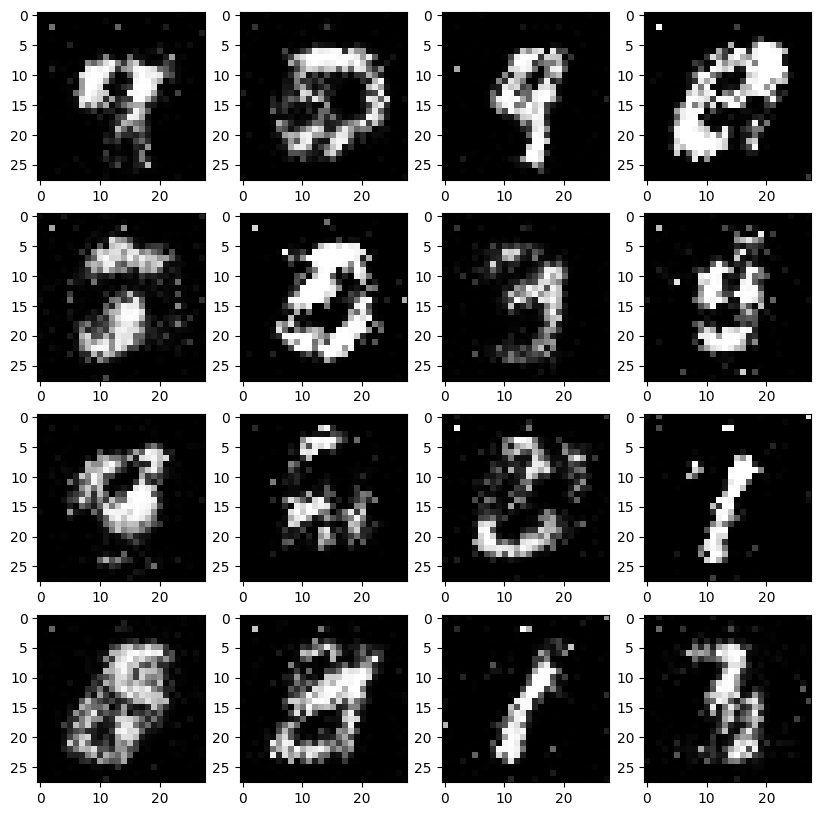

In [16]:
import torch
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt

gen.eval()
z_dim = 64

# Generation a batch of fake images
noise = torch.randn(16, z_dim).to(device)
with torch.no_grad():
    fake_images = gen(noise).reshape(-1, 1, 28, 28)
    fake_images = (fake_images + 1) / 2

# plot image
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i].cpu().numpy().squeeze(), cmap='gray')


# Training another GAN with a custom dataset

First i will try resizing all the lego images to 28x28 (as the first GAN), then i will try to do it with bigger images (for that, i'll need to change the parameters of the architecture)

In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

class LegoDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = []
        for filename in os.listdir(root_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                self.dataset.append((filename,))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataset[idx][0])
        image = Image.open(img_name).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        # Return as dictionary
        sample = {'image': image}
        return image # i return the tensor directly for simplicity (instead of the dict)

    def __plot__(self):
        fig = plt.figure(figsize=(8, 8))
        for i, sample in enumerate(self):
            print(i, sample['image'].shape)

            ax = plt.subplot(1, 4, i + 1)
            ax.imshow(sample['image'].permute(1, 2, 0).numpy())
            ax.set_title('Sample #{}'.format(i))
            ax.axis('off')

            if i == 3:
                plt.show()
                break


# lego_dataset = LegoDataset(root_dir=PATH, transform=transform)
# lego_dataset.__plot__()




In [23]:
lego_disc = Discriminator(image_dim).to(device)
lego_gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 1 channel
])

lego_dataset = LegoDataset(root_dir="./data/lego_dataset/lego-brick-images/versions/4/dataset", transform=transforms)
loader = DataLoader(lego_dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(lego_disc.parameters(), lr=lr)
opt_gen = optim.Adam(lego_gen.parameters(), lr=lr)
criterion = nn.BCELoss()

# Writers for TensorBoard
# writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
# writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0

In [37]:
import shutil
import datetime

patience = 5  # stop if no improvement after 5 epochs, at the end i didn't use this but i always put it on my codes
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    for batch_idx, real in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        # Train Discriminator
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = lego_gen(noise)
        disc_real = lego_disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = lego_disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        lego_disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        # Train Generator
        output = lego_disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        lego_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                # adding the images to the TensorBoard logs
                """ writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                ) """
                step += 1

    # Early Stopping
    ''' epoch_loss = lossG.item()
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break '''

# Zip the runs/ folder when training finishes
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
shutil.make_archive(f"runs_backup_{timestamp}", 'zip', "runs")

Epoch [0/100] Batch 0/400 Loss D: 0.6860, Loss G: 0.7400
Epoch [1/100] Batch 0/400 Loss D: 0.4541, Loss G: 0.8133
Epoch [2/100] Batch 0/400 Loss D: 0.3418, Loss G: 1.3211
Epoch [3/100] Batch 0/400 Loss D: 0.3251, Loss G: 1.3371
Epoch [4/100] Batch 0/400 Loss D: 0.1510, Loss G: 2.4896
Epoch [5/100] Batch 0/400 Loss D: 0.4346, Loss G: 1.3697
Epoch [6/100] Batch 0/400 Loss D: 0.4367, Loss G: 1.7629
Epoch [7/100] Batch 0/400 Loss D: 0.4761, Loss G: 1.0717
Epoch [8/100] Batch 0/400 Loss D: 0.6547, Loss G: 0.9542
Epoch [9/100] Batch 0/400 Loss D: 0.1598, Loss G: 3.0442
Epoch [10/100] Batch 0/400 Loss D: 0.3617, Loss G: 1.5908
Epoch [11/100] Batch 0/400 Loss D: 0.2759, Loss G: 2.5136
Epoch [12/100] Batch 0/400 Loss D: 0.1904, Loss G: 2.5018
Epoch [13/100] Batch 0/400 Loss D: 0.3306, Loss G: 1.6511
Epoch [14/100] Batch 0/400 Loss D: 0.4742, Loss G: 1.2239
Epoch [15/100] Batch 0/400 Loss D: 0.5011, Loss G: 1.7047
Epoch [16/100] Batch 0/400 Loss D: 0.1450, Loss G: 2.2956
Epoch [17/100] Batch 0/4

'/home/lexo/dev/models/GAN/Simple_GAN/runs_backup_20250815_211005.zip'

In [38]:
torch.save(lego_gen.state_dict(), "./models/lego_generator_final.pth")
torch.save(lego_disc.state_dict(), "./models/lego_discriminator_final.pth")

# plot of a subset of 16 random images from the dataset

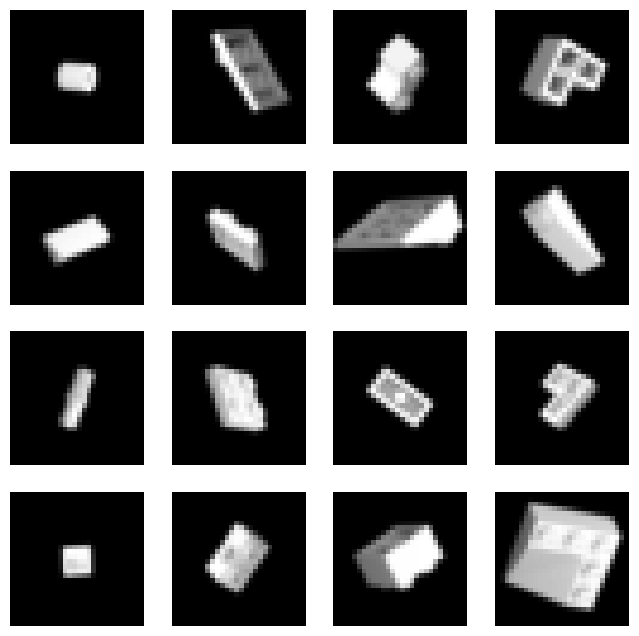

In [44]:
# plot of a subset of 16 random images from the dataset without using the dataset class
fig = plt.figure(figsize=(8, 8))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    img = lego_dataset[i].reshape(28, 28).numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

# plot of 16 GAN generated lego bricks

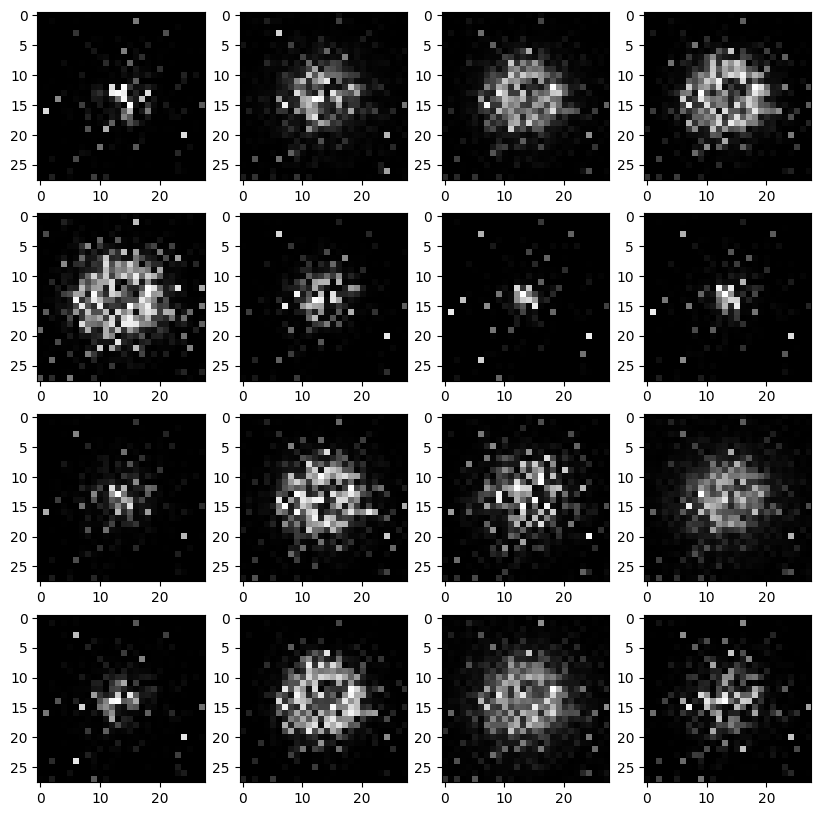

In [41]:
import torch
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt

lego_gen.eval()
z_dim = 64

# Generation a batch of fake images
noise = torch.randn(16, z_dim).to(device)
with torch.no_grad():
    fake_images = lego_gen(noise).reshape(-1, 1, 28, 28)
    fake_images = (fake_images + 1) / 2

# plot image
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i].cpu().numpy().squeeze(), cmap='gray')


# Conclusion

The results are bad, i think that is because of two main reasons, first: there are many different lego pieces in the dataset, so this simple nn is not enough, second: The original size of the lego images is a lot bigger than 28x28 so there are some features that are't being captured.

To achieve good lego bricks image generation is needed a more complex GAN architecture than this one.